## **Plantilla**

In [215]:
import pandas as pd

ruta = "https://raw.githubusercontent.com/VillaltaE/netflix_churn/refs/heads/main/netflix_customer_churn.csv"
df = pd.read_csv(ruta)

model_cols = [
    "subscription_type",
    "watch_hours",
    "last_login_days",
    "monthly_fee",
    "number_of_profiles",
    "avg_watch_time_per_day",
    "payment_method"
]

X = df[model_cols]
y = df["churned"]

X.head(), y.value_counts(normalize=True)


(  subscription_type  watch_hours  last_login_days  monthly_fee  \
 0             Basic        14.73               29         8.99   
 1          Standard         0.70               19        13.99   
 2          Standard        16.32               10        13.99   
 3           Premium         4.51               12        17.99   
 4          Standard         1.89               13        13.99   
 
    number_of_profiles  avg_watch_time_per_day payment_method  
 0                   1                    0.49      Gift Card  
 1                   5                    0.03      Gift Card  
 2                   2                    1.48         Crypto  
 3                   2                    0.35         Crypto  
 4                   2                    0.13         Crypto  ,
 churned
 1    0.503
 0    0.497
 Name: proportion, dtype: float64)

## **Importar lo necesario**

In [216]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt



## **Definir columnas por tipo**



In [217]:
categorical_cols = ["subscription_type","payment_method"]
numeric_cols = [
    "watch_hours",
    "last_login_days",
    "monthly_fee",
    "number_of_profiles",
    "avg_watch_time_per_day"
]


In [218]:
print(f"La columna con problemas es: {categorical_cols[1]}")

La columna con problemas es: payment_method


## **Crear el preprocesador**

In [219]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ("num", RobustScaler(), numeric_cols)
    ],
    remainder='passthrough'
)


## **Train/Validation/Test split (80/20)**


In [ ]:
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [221]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [222]:
X_train.shape, X_test.shape

((4000, 7), (1000, 7))

## **Armar el pipeline**

In [223]:
rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForest(max_depth=5))
])

## **Entrenar**

In [224]:
rf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subscription_type',
                                                   'payment_method']),
                                                 ('num', RobustScaler(),
                                                  ['watch_hours',
                                                   'last_login_days',
                                                   'monthly_fee',
                                                   'number_of_profiles',
                                                   'avg_watch_time_per_day'])])),
                ('model', RandomForestClassifier(max_depth=5))])

## **Validación del modelo**

### Validación del modelo a partir de un conjunto de datos

In [225]:
y_val_pred = rf.predict(X_val)

### Reporte de métricas de clasificación

In [226]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       497
           1       0.93      0.98      0.95       503

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



### Matriz de Confusión

In [227]:
matriz = confusion_matrix(y_val, y_val_pred)

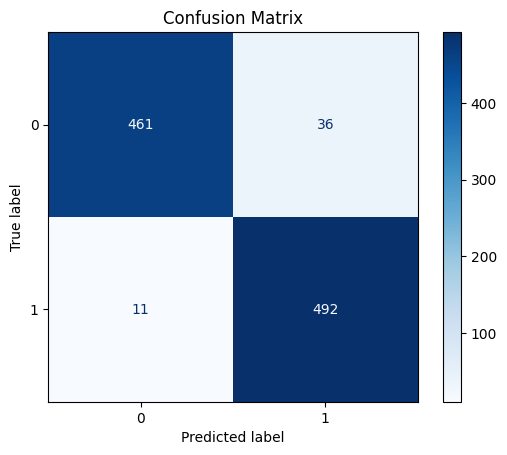

In [228]:
#Gráfico de la matriz de confusión que nos muestra que tan bien está prediciendo
vis_confusion = ConfusionMatrixDisplay(confusion_matrix=matriz)
vis_confusion.plot(cmap='Blues');
plt.title('Confusion Matrix')

plt.show()

### Curva ROC

In [229]:
print(roc_curve(y_val, y_val_pred))

(array([0.        , 0.07243461, 1.        ]), array([0.        , 0.97813121, 1.        ]), array([inf,  1.,  0.]))


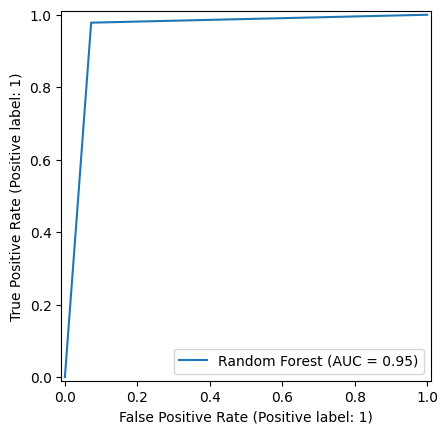

In [230]:
RocCurveDisplay.from_predictions(y_val,y_val_pred,name='Random Forest');

In [ ]:
#Gráfico alternativo de la curva ROC
# Generar un predictor sin habilidad
ns_probs = [0 for _ in range(len(y_val))]
# Calculo de la métrica auc
ns_auc = roc_auc_score(y_val, ns_probs)
rf_auc = roc_auc_score(y_val, y_val_pred)

# Cáculo de la curva roc
ns_fpr, ns_tpr, t = roc_curve(y_val, ns_probs)
rf_fpr, lr_tpr, t = roc_curve(y_val, y_val_pred)

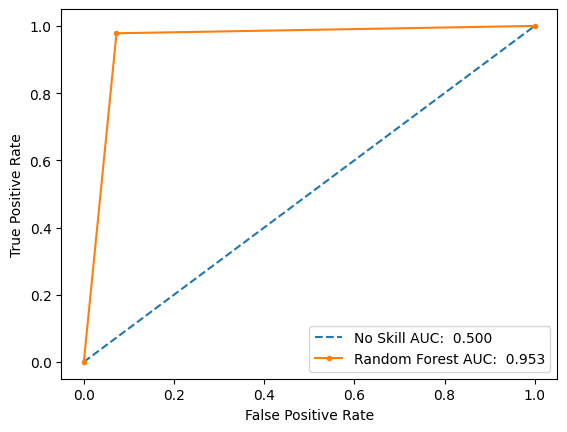

In [232]:
#Gráfico de la curva ROC
plt.plot(ns_fpr, ns_tpr, linestyle='--', label=f'No Skill AUC: {ns_auc: .3f}')
plt.plot(rf_fpr, lr_tpr, marker='.', label=f'Random Forest AUC: {rf_auc: .3f}')
# Etiquetas de los ejes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Mostrar la leyenda
plt.legend()
# Mostrar el gráfico
plt.show()

### Curva Precisión Sensibilidad

In [233]:
from sklearn.metrics import PrecisionRecallDisplay

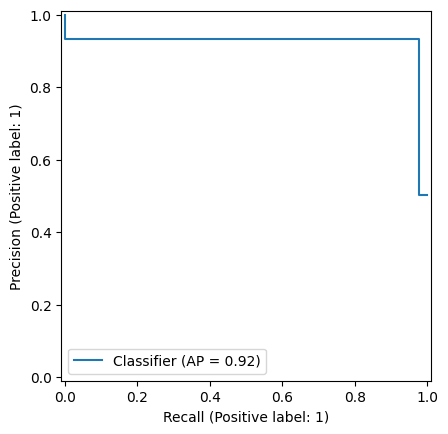

In [234]:
PrecisionRecallDisplay.from_predictions(y_val, y_val_pred);

In [235]:
#Cálculo de las métricas recall y precisión
rf_precision, rf_recall, _ = precision_recall_curve(y_val, y_val_pred)
av_pre_score = round(average_precision_score(y_val, y_val_pred),3)
no_skill = len(y_val[y_val==1]) / len(y_val)


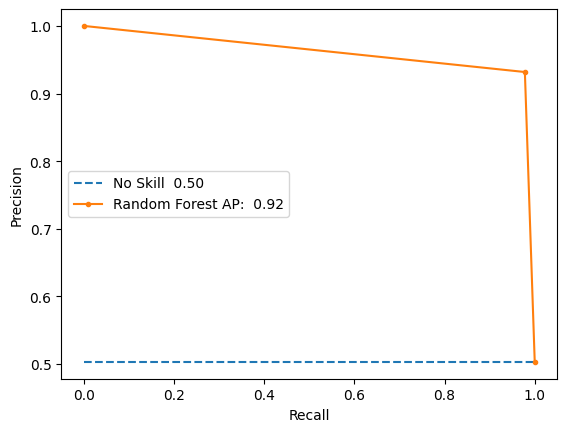

In [236]:
#Gŕafico de curva precision sensibilidad
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill {no_skill: .2f}')
plt.plot(rf_recall, rf_precision, marker='.', label= f'Random Forest AP: {av_pre_score: .2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()

plt.show()


### Interpretación de las métricas y gráficos

### Exactitud

In [237]:
print(f'La exactitud del modelo con los datos de validación es: {accuracy_score(y_val, y_val_pred)}')

La exactitud del modelo con los datos de validación es: 0.953


### Precisión

In [238]:
print(f'La precisión del modelo con los datos de validación es: {precision_score(y_val, y_val_pred)}')

La precisión del modelo con los datos de validación es: 0.9318181818181818


### Sensibilidad

In [239]:
print(f'La sensibilidad del modelo con los datos de validación es: {recall_score(y_val, y_val_pred)}')

La sensibilidad del modelo con los datos de validación es: 0.9781312127236581


### Validación del modelo a partir de validación cruzada

In [240]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate

In [241]:
#Separamos las columnas predictoras y la que va a ser predecida
_X = df[model_cols]

_y = df['churned']

In [242]:
_X.columns

Index(['subscription_type', 'watch_hours', 'last_login_days', 'monthly_fee',
       'number_of_profiles', 'avg_watch_time_per_day', 'payment_method'],
      dtype='object')

### **Armar el pipeline para la validación cruzada**

In [243]:
#Creamos el objeto skfold que se encargará de la validación cruzada
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [244]:
cross_val_random = cross_validate(rf, _X, _y, cv=skfold, scoring=['precision','recall'])

In [245]:
cross_val_random

{'fit_time': array([0.30002713, 0.28989053, 0.31023216, 0.29306293, 0.28631425]),
 'score_time': array([0.02302647, 0.02394032, 0.02227592, 0.0233686 , 0.02180958]),
 'test_precision': array([0.92857143, 0.90538033, 0.93090211, 0.92120075, 0.93295019]),
 'test_recall': array([0.95626243, 0.97017893, 0.96421471, 0.97614314, 0.96819085])}

In [246]:
print(f'La media de la métrica precisión en la validación cruzada es : \
{round(cross_val_random['test_precision'].mean(),2)} ± {round(cross_val_random['test_precision'].std(),2)}\
')

La media de la métrica precisión en la validación cruzada es : 0.92 ± 0.01


In [247]:
print(f'La media de la métrica sensibilidad en la validación cruzada es: \
{round(cross_val_random['test_recall'].mean(),2)} ± {round(cross_val_random['test_recall'].std(),2)}\
        ')

La media de la métrica sensibilidad en la validación cruzada es: 0.97 ± 0.01        


## **Evaluar**

### **Prueba del modelo Regresión Logística con los datos de prueba**

In [248]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.93      0.95       497
           1       0.93      0.98      0.95       503

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



#### Matriz de confusión

In [249]:
print(confusion_matrix(y_test, y_pred))

[[461  36]
 [ 11 492]]


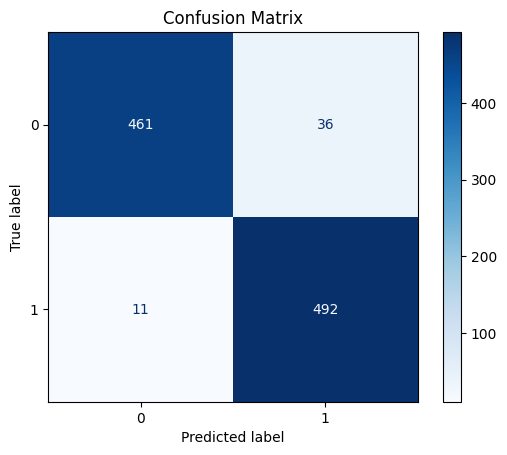

In [250]:
visualizacion = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred));

visualizacion.plot(cmap='Blues')

plt.title('Confusion Matrix')

plt.show()

### Exactitud

In [251]:
print(f'La precision del modelo es:{accuracy_score(y_test, y_pred)}')

La precision del modelo es:0.953


### Precisión

In [252]:
print(f'La precisión del modelo con los datos de prueba: {precision_score(y_test, y_pred)}') 

La precisión del modelo con los datos de prueba: 0.9318181818181818


### Sensibilidad

In [253]:
print(f'La sensibilidad del modelo con los datos de prueba: {recall_score(y_test, y_pred)}') 

La sensibilidad del modelo con los datos de prueba: 0.9781312127236581


### Curva ROC

In [254]:
print(roc_curve(y_test, y_pred))

(array([0.        , 0.07243461, 1.        ]), array([0.        , 0.97813121, 1.        ]), array([inf,  1.,  0.]))


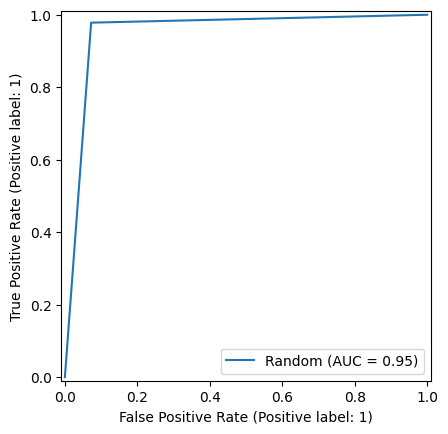

In [255]:
RocCurveDisplay.from_predictions(y_test,y_pred,name='Random');

In [256]:
#Gráfico alternativo de la curva ROC
# Generar un predictor sin habilidad
ns_probs = [0 for _ in range(len(y_test))]
# Calculo de la métrica auc
ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, y_pred)

# Cáculo de la curva roc
ns_fpr, ns_tpr, t = roc_curve(y_test, ns_probs)
rf_fpr, lr_tpr, t = roc_curve(y_test, y_pred)

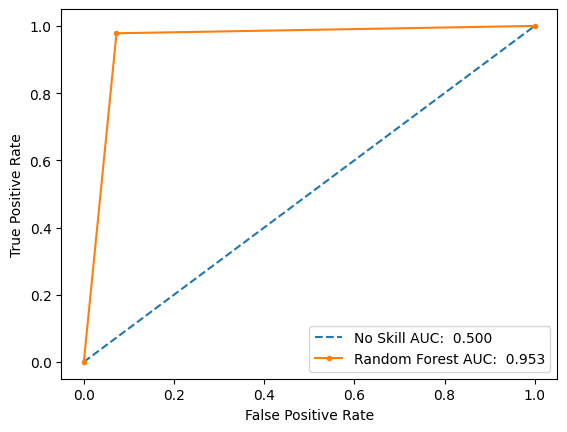

In [257]:
#Gráfico de la curva ROC
plt.plot(ns_fpr, ns_tpr, linestyle='--', label=f'No Skill AUC: {ns_auc: .3f}')
plt.plot(rf_fpr, lr_tpr, marker='.', label=f'Random Forest AUC: {rf_auc: .3f}')
# Etiquetas de los ejes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Mostrar la leyenda
plt.legend()
# Mostrar el gráfico
plt.show()

### Curva Precisión vs Sensibilidad

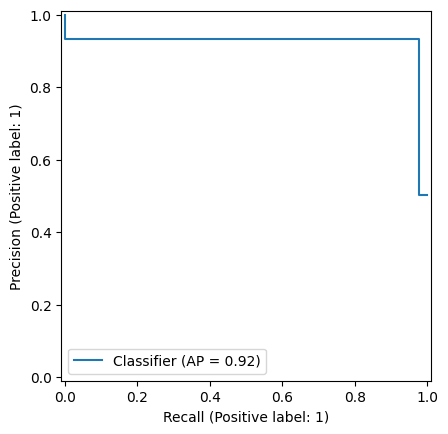

In [ ]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred);

In [259]:
#Cálculo de las métricas recall y precisión
rf_precision, rf_recall, _ = precision_recall_curve(y_test, y_pred)
av_pre_score = round(average_precision_score(y_test, y_pred),3)
no_skill = len(y_test[y_test==1]) / len(y_test)


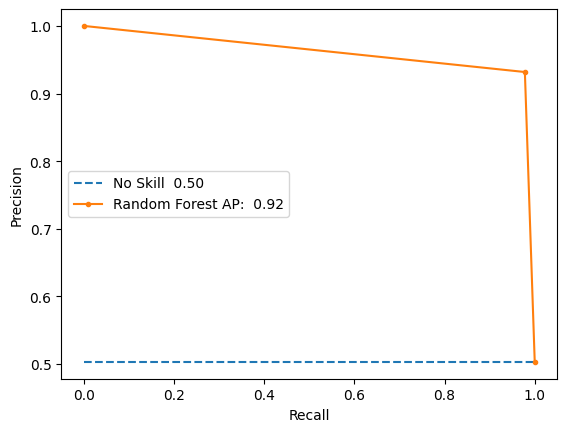

In [260]:
#Gŕafico de curva precision sensibilidad
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill {no_skill: .2f}')
plt.plot(rf_recall, rf_precision, marker='.', label= f'Random Forest AP: {av_pre_score: .2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()

plt.show()


### Interpretación de las métricas y gráficos

En el gráfico ROC, observamos que el modelo tiene una excelente capacidad para distinguir entre las dos clases de churn, respaldado por un AUC de 0.95. Esto significa que el modelo es altamente eficaz separando a los clientes que se irán de los que se quedarán.

Otro aspecto crítico es la estabilidad del modelo: como se ve en la curva Precisión vs Sensibilidad (Recall), a medida que aumentamos la sensibilidad para capturar a más clientes en riesgo, la precisión no decae bruscamente, sino que se mantiene constante y en un valor muy alto (93%).

En conclusión, el modelo logra un balance óptimo entre precisión y sensibilidad, permitiéndonos identificar al 93% de los desertores con un margen de error mínimo. Este rendimiento global se resume en el Puntaje Promedio de Precisión (AP) de 0.92, lo que garantiza una alta rentabilidad en las acciones de retención.

## **Probabilidades / API**

In [261]:
#Probabilidad de churn=1
y_proba = rf.predict_proba(X_test)[:, 1]
y_proba[:15]


array([0.01986199, 0.76760179, 0.51975316, 0.9071043 , 0.85147862,
       0.91775135, 0.805461  , 0.98359255, 0.5017849 , 0.54441077,
       0.04991102, 0.19395963, 0.14097561, 0.05590166, 0.04735033])

## **Función de predicción**

In [264]:
def predict_cliente(input_dict):
    
    #df con las caracteristicas del cliente a predecir
    df_input = pd.DataFrame([input_dict])
    #Guardamos la variable id
    id = int(df_input['customer_id'].iloc[0])
    #luego la eliminamos del df para que no intervenga en el modelo
    datos_input = df_input.drop(columns=['customer_id'])
    #corremos el modelo    
    proba = rf.predict_proba(datos_input)[0, 1]
    pred = "Va a cancelar" if proba >= 0.5 else "Va a continuar"
    # la salida: id junto con la predicción del modelo
    return {
        "customer_id": id,
        "prevision": pred,
        "probabilidad": round(float(proba), 3)
    }


## **Probar con un cliente / Manual**

In [265]:
cliente_ejemplo = {
    "customer_id": 1,
    "subscription_type": "Standard",
    "watch_hours": 30,
    "last_login_days": 5,
    "monthly_fee": 15,
    "number_of_profiles": 4,
    "avg_watch_time_per_day": 0.29,
    "payment_method": "Paypal"

}

print(f'El resultado del modelo es:{predict_cliente(cliente_ejemplo)}')


El resultado del modelo es:{'customer_id': 1, 'prevision': 'Va a continuar', 'probabilidad': 0.146}
